# 7 MUSCLES CLASSIFICATION WITH (INTRA+INTER)PERSONAL VALIDATION

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # 7 MUSCLES CLASSIFICATION + (INTER/INTRA)PERSONAL VALIDATION

# Imports
import os
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow Model
import tensorflow as tf
from functools import reduce 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv1D, LeakyReLU, MaxPooling1D, LSTM, GlobalAveragePooling1D, Dense, \
	Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy

# Weight and Biases
import wandb
from wandb.keras import WandbMetricsLogger

# Model Metrics
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

# Ensuring Exact Reproducibility
np.random.seed(16)
tf.random.set_seed(16)
# export TF_ENABLE_ONEDNN_OPTS=0 #somehow doesn't work


# Defining important lists
subjects = ["156", "185", "186", "188", "189", "190", "191", "192", "193", "194"]
muscles = ['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF']

# ### Method: Preserving Onset and Window = 1000ms
window = 1000  # in ms (total window size)
left_shift = 100  # in ms (left shift from detected onset)


# ## Load TFRecords

# Iterate over the whole dataset to count records/samples
# Reference: https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/
def countRecords(ds: tf.data.Dataset):
	count = 0
	if tf.executing_eagerly():
		# TF v2 or v1 in eager mode
		for _ in ds:
			count = count + 1
	else:
		# TF v1 in non-eager mode
		iterator = tf.compat.v1.data.make_one_shot_iterator(ds)
		next_batch = iterator.get_next()
		with tf.compat.v1.Session() as sess:
			try:
				while True:
					sess.run(next_batch)
					count = count + 1
			except tf.errors.OutOfRangeError:
				pass
	return count


AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1024


def read_tfrecord(serialized_example, export_subject=False):
	tfrecord_format = (
		{
			'label': tf.io.FixedLenFeature([], tf.int64),
			'feature': tf.io.FixedLenFeature([window], tf.float32),
			'subject': tf.io.FixedLenFeature([], tf.int64)
		}
	)
	example = tf.io.parse_single_example(serialized_example, tfrecord_format)
	f = tf.reshape(example['feature'], [window, 1])
	f.set_shape([window, 1])
	# One-hot encode the label to match the expected shape for categorical_crossentropy
	label = tf.one_hot(example['label'], depth=7)
	if export_subject:
		return f, label, example['subject']
	return f, label


def get_dataset(tf_record_name, train_or_valid):
	# dataset = load_dataset(filename)
	dataset = tf.data.TFRecordDataset(tf_record_name)
	dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
	dataset_samples = countRecords(dataset)
	print(f" - Number of {train_or_valid} Samples: ", dataset_samples)
	dataset = dataset.shuffle(dataset_samples)
	dataset = dataset.prefetch(buffer_size=AUTOTUNE)
	dataset = dataset.batch(BATCH_SIZE)
	return dataset


# In[ ]:


print("## For Intrapersonal-CV:")
train_dataset = get_dataset(f'tfrecords/all_mixed_train_{window}ms.tfrecord', 'Train')
valid_dataset = get_dataset(f'tfrecords/all_mixed_val_{window}ms.tfrecord', 'Validation')
print("\n ## For Interpersonal-LOSOCV:")
all_subjects_loo_data = [get_dataset(f'tfrecords/mixed_shuffled_subject_{i}_{window}ms', f"Subject_{i}") for i in
                         range(1, 11)]


# ## Verifying the shapes of: LOO, Training and Validation

# In[ ]:


# print('# Training:')
# for feature, label in train_dataset:
# 	print(f'\t - label={label.shape}, feature={feature.shape}')
#
# print('# Validation:')
# for feature, label in valid_dataset:
# 	print(f'\t - label={label.shape}, feature={feature.shape}')
#
# for subj_idx, subj in enumerate(all_subjects_loo_data):
# 	print(f'# Subject_{subj_idx + 1}:')
# 	for feature, label in subj:
# 		print(f'\t - label={label.shape}, feature={feature.shape}')


# # Useful Functions for the Training

# In[ ]:


def clear_and_create_directory(directory):
	"""Check if a directory exists and clear it, then recreate it."""
	if os.path.exists(directory):
		# Remove the directory and all its contents
		shutil.rmtree(directory)
		print(f"Old \"{directory}\" directory of the previous model deleted!")
	# Create the directory again
	os.makedirs(directory, exist_ok=True)


# In[ ]:


# def plotting_loss_and_accuracy_over_epochs(history_namee, title, is_to_show=False):
# 	h = np.load(history_namee + '.npy', allow_pickle=True).item()

# 	min_val_categ_crossentropy = round(min(h['val_loss']), 4)
# 	best_v_accu = round(max(h['val_accuracy']), 3) * 100

# 	# Find the epoch with the best validation accuracy
# 	best_val_acc_epoch = np.argmax(h['val_accuracy'])

# 	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# 	fig.suptitle(title, fontsize=18, y=0.99)
# 	ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
# 	ax2.set_title(f'Accuracy (best_val_acc={best_v_accu}%)')
# 	ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
# 	ax2.set(xlabel='Epoch', ylabel='Accuracy')
# 	ax1.plot(h['loss'], color="cornflowerblue", linewidth=3)
# 	ax1.plot(h['val_loss'], color="lightsteelblue", linewidth=3)
# 	ax1.legend(['Training Loss', 'Validation Loss'])
# 	ax2.plot(h['accuracy'], color="gold", linewidth=3)
# 	ax2.plot(h['val_accuracy'], color="darkorange", linewidth=3)
# 	ax2.legend(['Training Accuracy', 'Validation Accuracy'])
# 	# Add a red 'X' mark at the epoch where the best validation accuracy occurs
# 	ax2.scatter(best_val_acc_epoch, h['val_accuracy'][best_val_acc_epoch], color='red', marker='X', s=100)
# 	plt.savefig(f"results_figures/{title}")

# 	if is_to_show:
# 		plt.show()

# Function to plot single history data
def plotting_loss_and_accuracy_over_epochs(history_namee, title, is_to_show=False):
	h = np.load(history_namee + '.npy', allow_pickle=True).item()
	
	min_val_categ_crossentropy = round(min(h['val_loss']), 4)
	best_v_accu = round(max(h['val_accuracy']), 3) * 100
	
	# Find the epoch with the best validation accuracy
	best_val_acc_epoch = np.argmax(h['val_accuracy'])
	
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
	fig.suptitle(title, fontsize=18, y=0.99)
	ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
	ax2.set_title(f'Accuracy (best_val_acc={best_v_accu}%)')
	ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
	ax2.set(xlabel='Epoch', ylabel='Accuracy')
	
	ax1.plot(h['loss'], color="cornflowerblue", linewidth=3)
	ax1.plot(h['val_loss'], color="lightsteelblue", linewidth=3)
	ax1.legend(['Training Loss', 'Validation Loss'])
	ax1.grid(True)
	
	ax2.plot(h['accuracy'], color="gold", linewidth=3)
	ax2.plot(h['val_accuracy'], color="darkorange", linewidth=3)
	ax2.legend(['Training Accuracy', 'Validation Accuracy'])
	ax2.grid(True)
	
	# Add a red 'X' mark at the epoch where the best validation accuracy occurs
	ax2.scatter(best_val_acc_epoch, h['val_accuracy'][best_val_acc_epoch], color='red', marker='X', s=100)
	
	plt.savefig(f"results_figures/{title}.png")
	
	if is_to_show:
		plt.show()

# Function to plot combined loss and accuracy
def plot_combined_loss_and_accuracy(histories, title, is_to_show=False):
	num_epochs = len(histories[0]['loss'])
	
	# Initialize lists to store summed values
	sum_train_loss = np.zeros(num_epochs)
	sum_val_loss = np.zeros(num_epochs)
	sum_train_accuracy = np.zeros(num_epochs)
	sum_val_accuracy = np.zeros(num_epochs)
	
	# Sum values for all subjects
	for h in histories:
	    sum_train_loss += np.array(h['loss'])
	    sum_val_loss += np.array(h['val_loss'])
	    sum_train_accuracy += np.array(h['accuracy'])
	    sum_val_accuracy += np.array(h['val_accuracy'])
	
	# Calculate averages
	avg_train_loss = sum_train_loss / len(histories)
	avg_val_loss = sum_val_loss / len(histories)
	avg_train_accuracy = sum_train_accuracy / len(histories)
	avg_val_accuracy = sum_val_accuracy / len(histories)
	
	min_val_categ_crossentropy = round(min(avg_val_loss), 4)
	best_v_accu = round(max(avg_val_accuracy), 3) * 100
	
	# Find the epoch with the best validation accuracy
	best_val_acc_epoch = np.argmax(avg_val_accuracy)
	
	# Plotting
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
	fig.suptitle(title, fontsize=18, y=0.99)
	ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
	ax2.set_title(f'Accuracy (best_val_acc={best_v_accu}%)')
	ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
	ax2.set(xlabel='Epoch', ylabel='Accuracy')
	
	ax1.plot(avg_train_loss, color="cornflowerblue", linewidth=3)
	ax1.plot(avg_val_loss, color="lightsteelblue", linewidth=3)
	ax1.legend(['Training Loss', 'Validation Loss'])
	ax1.grid(True)
	
	ax2.plot(avg_train_accuracy, color="gold", linewidth=3)
	ax2.plot(avg_val_accuracy, color="darkorange", linewidth=3)
	ax2.legend(['Training Accuracy', 'Validation Accuracy'])
	ax2.grid(True)
	
	# Add a red 'X' mark at the epoch where the best validation accuracy occurs
	ax2.scatter(best_val_acc_epoch, avg_val_accuracy[best_val_acc_epoch], color='red', marker='X', s=100)
	
	plt.savefig(f"results_figures/{title}.png")
	
	if is_to_show:
	    plt.show()

# In[ ]:


def serializing_datasets(train_dataset_to_serialize, valid_dataset_to_serialize):
	train_features_list = [];
	train_labels_list = []
	valid_features_list = [];
	valid_labels_list = []

	for feature_array, label_array in train_dataset_to_serialize:
		for i in range(label_array.shape[0]):
			train_features_list.append(feature_array[i])
			train_labels_list.append(label_array[i])

	for feature_array, label_array in valid_dataset_to_serialize:
		for i in range(label_array.shape[0]):
			valid_features_list.append(feature_array[i])
			valid_labels_list.append(label_array[i])

	train_features = np.array(train_features_list)
	train_labels = np.array(train_labels_list)
	valid_features = np.array(valid_features_list)
	valid_labels = np.array(valid_labels_list)

	return train_features, train_labels, valid_features, valid_labels


# In[ ]:


def plot_confusion_matrix(x, y, color, title, is_to_show=False):
	# Find the filename of the best model saved during training
	best_model_filename = max(glob.glob('model1/best_model_epoch_*_val_acc_*.h5'), key=os.path.getctime)
	# Load the best model
	best_model = load_model(best_model_filename)

	predictions_hot = best_model.predict(x)
	predictions = np.argmax(predictions_hot, axis=1)
	np.set_printoptions(suppress=True)
	print("Some y Predicted\t", predictions[:30])
	y_list = np.argmax(y, axis=1)
	print("Some y Label\t\t", y_list[:30])

	cm = confusion_matrix(y_list, predictions)
	plt.figure(figsize=(15, 10))
	ax = sn.heatmap(cm, annot=True, cmap=color, fmt='d')
	ax.set_xlabel('Predicted Values')
	ax.set_ylabel('Actual Values ')
	ax.xaxis.set_ticklabels(muscles)
	ax.yaxis.set_ticklabels(muscles)

	np.set_printoptions(precision=3)
	precision, recall, f1, _ = score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1))
	f1_micro = f1_score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1), average='micro')
	print(f'precision: {precision}')
	print(f'recall: {recall}')
	print(f'fscore: {f1}')
	print(f'fscore_micro: {f1_micro:.3f}')

	title = title + f'(F1score_micro = {f1_micro:.3})'
	ax.set_title(title + '\n\n')
	ax.xaxis.set_label_position('top')
	ax.xaxis.set_ticks_position('top')
	plt.savefig(f"results_figures/{title}.png")

	if is_to_show:
		plt.show()

	return precision, recall, f1, f1_micro

# In[ ]:
	
	
def plot_average_wrong_classification_percentages(all_percentages):
	# Convert list of arrays into a single 2D array for easier manipulation
	all_percentages = np.array(all_percentages)

	# Calculate the average and standard deviation of each muscle's wrong classification percentage
	average_percentages = np.mean(all_percentages, axis=0)
	std_percentages = np.std(all_percentages, axis=0)
	title_avg = "Interpersonal Overall Validation Percentages of Wrongly Classified Muscles"

	# Setting the plotting area and style
	sn.set(style="whitegrid")
	plt.figure(figsize=(10, 6))

	# Plot for average percentages with error bars
	bars_avg = sn.barplot(x=muscles, y=average_percentages, palette="viridis", ci=None)
	plt.errorbar(x=muscles, y=average_percentages, yerr=std_percentages, fmt='none', ecolor='black', elinewidth=2, capsize=5, capthick=2, marker='o', markersize=5)
	plt.xlabel('Muscles')
	plt.ylabel('Average Percentage of Wrong Classifications')
	plt.title(title_avg)
	plt.xticks(rotation=45)
	plt.tight_layout()
	plt.savefig(f"results_figures/{title_avg}.png")
	plt.show()



# %%
def plot_wrong_classification_percentages(model, x_data, y_data, title, is_to_show=False):
	# Ensure data is numpy array for compatibility with np.argmax and np.where
	predictions = model.predict(x_data)
	predicted_labels = np.argmax(predictions, axis=1)
	actual_labels = np.argmax(y_data, axis=1)

	# Making sure labels are numpy arrays
	if not isinstance(predicted_labels, np.ndarray):
		predicted_labels = np.array(predicted_labels)
	if not isinstance(actual_labels, np.ndarray):
		actual_labels = np.array(actual_labels)

	# Find incorrect indices using numpy operations
	incorrect_indices = np.where(predicted_labels != actual_labels)[0]

	# Count the frequency of each wrongly predicted muscle
	error_counts = {muscle: 0 for muscle in muscles}
	for label in actual_labels[incorrect_indices]:
		muscle_name = muscles[label]
		error_counts[muscle_name] += 1

	# Calculate percentages
	total_incorrect = len(incorrect_indices)
	percentages = [100 * count / total_incorrect for count in error_counts.values()]

	# Plotting
	sn.set(style="whitegrid")
	plt.figure(figsize=(10, 6))
	bars = sn.barplot(x=list(error_counts.keys()), y=percentages, palette="viridis")
	plt.xlabel('Muscles')
	plt.ylabel('Percentage of Wrong Classifications')
	plt.title(title)
	plt.xticks(rotation=45)

	# Adding text labels for percentages
	for p, pct in zip(bars.patches, percentages):
		bars.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
		              ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
		              textcoords='offset points')
	plt.tight_layout()
	plt.savefig(f"results_figures/{title}.jpg")

	if is_to_show:
		plt.show()
	return np.array(percentages)



# %%
def display_classification_samples(model, x_data, y_data, title, num_samples_per_row=4, total_samples=12,
                                   is_to_show=False):
	# Make predictions
	predictions = model.predict(x_data)
	predicted_labels = np.argmax(predictions, axis=1)
	actual_labels = np.argmax(y_data, axis=1)

	# Find correct and incorrect indices
	correct_indices = np.where(predicted_labels == actual_labels)[0]
	incorrect_indices = np.where(predicted_labels != actual_labels)[0]

	# Select random samples from correct and incorrect classifications
	if len(correct_indices) > total_samples:
		selected_correct = np.random.choice(correct_indices, total_samples, replace=False)
	else:
		selected_correct = correct_indices

	if len(incorrect_indices) > total_samples:
		selected_incorrect = np.random.choice(incorrect_indices, total_samples, replace=False)
	else:
		selected_incorrect = incorrect_indices

	# Plotting
	fig, axes = plt.subplots(4, num_samples_per_row, figsize=(3 * num_samples_per_row, 10), constrained_layout=True)
	fig.suptitle(title, fontsize=16)

	# Plot correct classifications
	for row in range(2):
		for idx in range(num_samples_per_row):
			ax = axes[row, idx]
			real_idx = idx + row * num_samples_per_row
			if real_idx < len(selected_correct):
				ax.plot(x_data[selected_correct[real_idx]])
				ax.set_title(f"Correct: {muscles[actual_labels[selected_correct[real_idx]]]}", color='lime',
				             fontsize=10)
				ax.set_xlabel('Time')
				ax.set_ylabel('Amplitude')
				ax.set_ylim([-0.3,0.3])
				ax.grid(True)
			else:
				ax.set_visible(False)  # Hide unused axes

	# Plot incorrect classifications
	# Adding a second title
	# fig.text(0.5, 0.5, 'Incorrectly Classified:', ha='center', va='center', fontsize=14, fontweight='bold')
	for row in range(2, 4):
		for idx in range(num_samples_per_row):
			ax = axes[row, idx]
			real_idx = idx + (row - 2) * num_samples_per_row
			if real_idx < len(selected_incorrect):
				ax.plot(x_data[selected_incorrect[real_idx]])
				ax.set_title(
					f"Wrong: {muscles[predicted_labels[selected_incorrect[real_idx]]]} (True: {muscles[actual_labels[selected_incorrect[real_idx]]]})",
					color='red', fontsize=10)
				ax.set_xlabel('Time')
				ax.set_ylabel('Amplitude')
				ax.set_ylim([-0.3,0.3])
				ax.grid(True)

	plt.savefig(f"results_figures/{title}.png")
	if is_to_show:
		plt.show()
		
# In[ ]:


def plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1_list,
                                   all_interpersonal_f1_micro_list):
	# Helper function to ensure metrics are single values
	def ensure_single_value(metrics):
		if isinstance(metrics[0], (list, np.ndarray)):  # checks if the first element is a list or ndarray
			metrics = [np.mean(metric) for metric in metrics]
		return metrics

	# Ensuring each metric is a single value by averaging if necessary
	all_interpersonal_precision = ensure_single_value(all_interpersonal_precision)
	all_interpersonal_recall = ensure_single_value(all_interpersonal_recall)
	all_interpersonal_f1_list = ensure_single_value(all_interpersonal_f1_list)
	all_interpersonal_f1_micro_list = ensure_single_value(all_interpersonal_f1_micro_list)

	subjects_names = [f"Subject_{subjects[i]}" for i in range(len(all_interpersonal_precision))]

	# Create a figure with subplots
	fig, axs = plt.subplots(2, 2, figsize=(20, 12))  # (15,12) before
	fig.suptitle('Interpersonal LOSOCV Validation Metrics Comparison', fontsize=18)
	bar_width = 0.35

	# Helper function to add value labels on top of bars
	def add_value_labels(ax):
		for i in ax.patches:
			ax.text(i.get_x() + i.get_width() / 2, i.get_height(),
			        round(i.get_height(), 2), ha='center', va='bottom')

	# Plot each metric with rotated x-axis labels
	for ax in axs.flat:
		ax.set_xticks(range(len(subjects_names)))
		ax.set_xticklabels(subjects_names, rotation=45, ha="right")  # Adjust rotation and alignment here

	# Plotting Precision
	axs[0, 0].bar(subjects_names, all_interpersonal_precision, color='b', width=bar_width)
	axs[0, 0].set_title(
		f'Interpersonal Precision (Overall Precision = {round(np.mean(all_interpersonal_precision), 3)})')
	axs[0, 0].set_xlabel('Subjects')
	axs[0, 0].set_ylabel('Precision')
	axs[0, 0].set_ylim([0, 1])
	add_value_labels(axs[0, 0])

	# Plotting Recall
	axs[0, 1].bar(subjects_names, all_interpersonal_recall, color='r', width=bar_width)
	axs[0, 1].set_title(f'Interpersonal Recall (Overall Recall = {round(np.mean(all_interpersonal_recall), 3)})')
	axs[0, 1].set_xlabel('Subjects')
	axs[0, 1].set_ylabel('Recall')
	axs[0, 1].set_ylim([0, 1])
	add_value_labels(axs[0, 1])

	# Plotting F1 Score
	axs[1, 0].bar(subjects_names, all_interpersonal_f1_list, color='g', width=bar_width)
	axs[1, 0].set_title(f'Interpersonal F1 Score (Overall F1 Score = {round(np.mean(all_interpersonal_f1_list), 3)})')
	axs[1, 0].set_xlabel('Subjects')
	axs[1, 0].set_ylabel('F1 Score')
	axs[1, 0].set_ylim([0, 1])
	add_value_labels(axs[1, 0])

	# Plotting Micro F1 Score
	axs[1, 1].bar(subjects_names, all_interpersonal_f1_micro_list, color='c', width=bar_width)
	axs[1, 1].set_title(
		f'Interpersonal F1 Micro Score (Overall F1 Micro Score = {round(np.mean(all_interpersonal_f1_micro_list), 3)})')
	axs[1, 1].set_xlabel('Subjects')
	axs[1, 1].set_ylabel('F1 Micro Score')
	axs[1, 1].set_ylim([0, 1])
	add_value_labels(axs[1, 1])

	# Improve layout and save the figure
	plt.tight_layout(rect=[0, 0.03, 1, 0.95])
	plt.savefig("results_figures/interpersonal_test_scores.png")
	plt.show()

	

	

# # Hybrid CNN-LSTM Model Implementation

# In[ ]:


# Check if GPU is available
if tf.test.gpu_device_name():
	print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
	print("Please install GPU version of TF")

# List physical GPU devices
print("Physical GPU devices:", tf.config.experimental.list_physical_devices('GPU'))

# ## Model Definition

# In[ ]:
# Hyperparameters


note = "testing inter graphs acc"

# epochs = 250  # For performance testing
epochs = 3  # For quick testing


lr = 0.01
scheduler = ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0001)  # Adjust patience as needed!!!!!!!

## CNN Layer 1
conv1D_1 = [32, 5, 1]  # number_filters,kernel_size and strides (Best so far)
# conv1D_1 = [32,50,1]  # number_filters,kernel_size and strides
dropout_1 = 0.3  # Dropout %
pool1D_1 = [2, 2]  # pool_size and strides

## CNN Layer 2
conv1D_2 = [64, 7, 1]  # number_filters,kernel_size and strides (Best so far)
# conv1D_2 = [64,25,1]  # <number_filters,kernel_size and strides
dropout_2 = 0.3  # Dropout %
pool1D_2 = [2, 2]  # pool_size and strides

#     ## CNN Layer 3
conv1D_3 = [96, 9, 1]  # number_filters,kernel_size and strides (Best so far)
# conv1D_3 = [96, 10, 1]  # number_filters,kernel_size and strides
dropout_3 = 0.3  # Dropout %
pool1D_3 = [2, 2]  # pool_size and strides

# Dense 1
dense_1 = 50  # nodes ->50
dense_dropout_1 = 0.3  # Dropout %
# LSTM 1
lstm_1 = 30  # lstm blocks ->30
lstm_dropout_1 = 0.3  # Dropout %
# Dense 3
dense_3 = 15  # nodes ->15
dense_dropout_3 = 0.3  # Dropout %


def model_creation():
	# Definition
	model = Sequential()
	model.add(InputLayer((window, 1)))  # InputLayer(BURST_WINDOW, N_CHANNELS)

	# CNN LAYER 1 (Conv1D + PReLU + MaxPooling + Dropout)
	model.add(Conv1D(filters=conv1D_1[0], kernel_size=conv1D_1[1], strides=conv1D_1[2], padding='same',
	                 name='cnn_layer_1'))  # TODO TRY WITH HIGHER KERNEL SIZE (ODD NUMBER!)
	model.add(LeakyReLU(alpha=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_1[0], strides=pool1D_1[1], padding='same'))
	model.add(Dropout(dropout_1))

	# CNN LAYER 2 (Conv1D + PReLU + MaxPooling + Dropout)
	model.add(
		Conv1D(filters=conv1D_2[0], kernel_size=conv1D_2[1], strides=conv1D_2[2], padding='same', name='cnn_layer_2'))
	model.add(LeakyReLU(alpha=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_2[0], strides=pool1D_2[1], padding='same'))
	model.add(Dropout(dropout_2))

	# CNN LAYER 3 (Conv1D + LeakyReLU + MaxPooling + Dropout)
	model.add(
		Conv1D(filters=conv1D_3[0], kernel_size=conv1D_3[1], strides=conv1D_3[2], padding='same', name='cnn_layer_3'))
	model.add(LeakyReLU(alpha=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_3[0], strides=pool1D_3[1], padding='same'))
	model.add(Dropout(dropout_3))

	# Global Average Pooling
	model.add(GlobalAveragePooling1D())

	# Dense 1:  To integrate the Dense Layer 1 effectively after GAP, we reshape the output to make it compatible with the dense layer expectations
	model.add(Reshape((1, -1)))
	model.add(Dense(dense_1))
	model.add(LeakyReLU(alpha=0.1))
	model.add(Dropout(dense_dropout_1))

	# LSTM LAYER 1 + Dropout
	model.add(LSTM(lstm_1, dropout=lstm_dropout_1))

	# Dense 3
	model.add(Dense(dense_3))
	model.add(LeakyReLU(alpha=0.1))
	model.add(Dropout(dense_dropout_3))

	# Softmax
	model.add(Dense(7, 'softmax'))  # Softmax

	print("A fresh New Model Created!")

	return model


model1 = model_creation()

# Summary
model1.summary()

# In[ ]:


# Logging Wandb Parameters
wandb.login(key="f326506abe0148d1ad9e19746d28efd5d596d434")
config = {"number of muscles": len(muscles),
          "number of subjects": len(subjects),  # used to be all_subject_dfs
          "LOSOCV": "On",
          "Shuffle": "On",
          "batch_size": BATCH_SIZE,
          "learning_rate": lr,
          "epochs": epochs,
          "scheduler": "ReduceLROnPlateau",
          "optimizer": "Adam",

          "CNN_1": conv1D_1,
          "CNN_1_Activation": "LeakyReLU",
          "CNN_1_Pool": pool1D_1,
          "CNN_1_dropout": dropout_1,

          "CNN_2": conv1D_2,
          "CNN_2_Activation": "LeakyReLU",
          "CNN_2_Pool": pool1D_2,
          "CNN_2_dropout": dropout_2,

          "CNN_3": conv1D_3,
          "CNN_3_Activation": "LeakyReLU",
          "CNN_3_Pool": pool1D_3,
          "CNN_3_dropout": dropout_3,

          "GAP": "On",

          "dense_1": dense_1,
          "dense_1_dropout": dense_dropout_1,

          "lstm_1": lstm_1,
          "lstm_1_dropout": lstm_dropout_1,

          "dense_3": dense_3,
          "dense_3_dropout": dense_dropout_3}

# ## Intrapersonal Performance Test: Cross-Validation

# In[ ]:


# Deleting the old directories of the previously trained models
clear_and_create_directory("model1")
clear_and_create_directory("histories")
clear_and_create_directory("results_figures")

# In[ ]:


# Initialising Wandb logging
wandb.init(project='Thesis', entity='firass-koli', config=config, name="Intrapersonal-CV", group=note)
# optimizer = Adam(learning_rate=wandb.config.learning_rate)
optimizer = Adam(learning_rate=wandb.config.learning_rate)

# In[ ]:


model1.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])  # TODO: Try DK (Learning rate)
cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5', save_best_only=True,
                     monitor='val_accuracy', mode='max')

# In[ ]:

# Training the model with the wandb callback
with tf.device("/gpu:0"):
	history = model1.fit(train_dataset, validation_data=valid_dataset, epochs=wandb.config.epochs,
	                     callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])

# Log the best validation accuracy and loss
wandb.log({"best_val_accuracy": max(history.history['val_accuracy']), "min_val_loss": min(history.history['val_loss'])})

model1.save('model1/full_model.h5')  # Saving the model in HDF5 format. You can change the path and filename as needed.

# In[ ]:


# ## In case of Keyboard Interrupt
# wandb.finish()


# In[ ]:


# Retrieve minimum loss and best accuracy
min_val_categ_crossentropy = round(min(history.history['val_loss']), 3)
best_val_accuracy = round(max(history.history['val_accuracy']), 3) * 100

history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_categ_crossentropy})'
np.save(history_name + '.npy', history.history)
# NOTE: The warnings you will see in the training are not relevant (it's due to the fact that the model is being saved so to be able to call it back in the future)
print(f'History (loss and accuracy) for training and validation saved in:\n-> {history_name}')

# In[ ]:


## Plotting Loss and Accuracy Metrics over Epochs
plotting_loss_and_accuracy_over_epochs(history_name, f'Intrapersonal Loss and Accuracy over Epochs', True)

## Serializing Datasets (train and val)
x_train, y_train, x_val, y_val = serializing_datasets(train_dataset, valid_dataset)

## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
# Confusion Matrix in Training
plot_confusion_matrix(x_train, y_train, 'Greens', f' Intrapersonal Training Confusion Matrix ')
# Confusion Matrix in Testing
intrapersonal_precision, intrapersonal_recall, intrapersonal_f1, intrapersonal_f1_micro = \
	plot_confusion_matrix(x_val, y_val, 'Blues', f' Intrapersonal Validation Confusion Matrix ')
# Classification Samples
display_classification_samples(model1, x_val, y_val, " Intrapersonal Validation Classification Samples ")
# Wrong Classification %
plot_wrong_classification_percentages(model1, x_val, y_val,
                                    " Intrapersonal Validation Percentages of Wrongly Classified Muscles ")

# In[ ]:


# Log the best validation accuracy and loss
wandb.log({"intrapersonal_best_accuracy": best_val_accuracy,
           "intrapersonal_min_val_loss": min_val_categ_crossentropy,
           # "intrapersonal_precision": intrapersonal_precision,
           # "intrapersonal_recall": intrapersonal_recall,
           # "intrapersonal_f1": intrapersonal_f1,
           "intrapersonal_f1_micro": intrapersonal_f1_micro
           })
wandb.finish()

# ## Interpersonal Performance Test: Leave-One-Subject-Out Cross-Validation (LOSOCV)

# In[ ]:


num_subjects = len(all_subjects_loo_data)
best_loo_validation_per_subject = [];
min_loo_val_loss_per_subject = []
all_interpersonal_precision = [];
all_interpersonal_recall = []
all_interpersonal_f1 = [];
all_interpersonal_f1_micro = []
all_percentages = []
all_histories = []

# In[ ]:


# LOSOCV Training Loop
for loo_subject in range(num_subjects):  # Change range to start from 0 to num_subjects-1
	print(f"Training with subject_{subjects[loo_subject]} as a validation set")

	# Deleting the old directories of the previously trained models
	clear_and_create_directory("model1")
	clear_and_create_directory("histories")

	# Initialising Wandb logging
	wandb.init(project='Thesis', entity='firass-koli', config=config, name=f"loo_test_subject_{subjects[loo_subject]}",
	           group=note)
	optimizer = Adam(learning_rate=wandb.config.learning_rate)

	# Creating a new model
	model1 = model_creation()

	# Compiling the model
	model1.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

	# Defining checkpoint path correctly with adjusted loo_subject index
	cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.h5', save_best_only=True,
	                     monitor='val_accuracy', mode='max')

	# Prepare training and validation datasets
	loo_valid_dataset = all_subjects_loo_data[loo_subject]
	loo_train_datasets = [d for i, d in enumerate(all_subjects_loo_data) if i != loo_subject]
	train_dataset = reduce(lambda x, y: x.concatenate(y), loo_train_datasets).shuffle(buffer_size=34000)  # Shuffle here
	# train_dataset = reduce(lambda x, y: x.concatenate(y), loo_train_datasets)  # Correct concatenation using lambda

	# Train the model with the correct validation dataset
	with tf.device("/gpu:0"):
		history = model1.fit(train_dataset, validation_data=loo_valid_dataset, epochs=wandb.config.epochs,
		                     callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])

	# Log the best validation accuracy and loss for each subject
	best_val_accuracy = round(max(history.history['val_accuracy']), 3) * 100
	min_val_loss = round(min(history.history['val_loss']), 3)

	print(f"Best Validation Accuracy for using Subject_{subjects[loo_subject]} as loo: {best_val_accuracy}%")
	print(f"Minimum Validation Loss for using Subject_{subjects[loo_subject]} as loo: {min_val_loss}")

	best_loo_validation_per_subject.append(best_val_accuracy)
	min_loo_val_loss_per_subject.append(min_val_loss)

	# Saving history
	history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_loss})_loo_subject_{subjects[loo_subject]}'
	np.save(history_name + '.npy', history.history)

	## Plotting Loss and Accuracy Metrics over Epochs
	plotting_loss_and_accuracy_over_epochs(history_name,
	                                       f'Subject_{subjects[loo_subject]} Loss and Accuracy over Epochs (Interpersonal with Subject_{subjects[loo_subject]} as loo) ')

	## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
	# Serializing Datasets (train and val)
	x_train, y_train, x_val, y_val = serializing_datasets(train_dataset, loo_valid_dataset)
	# Confusion Matrix in Training
	plot_confusion_matrix(x_train, y_train, 'Greens',
	                      f'Subject_{subjects[loo_subject]} Confusion Matrix of Interpersonal LOO Training WITHOUT Subject_{subjects[loo_subject]} ')
	# Confusion Matrix in Testing
	interpersonal_precision, interpersonal_recall, interpersonal_f1, interpersonal_f1_micro = \
		plot_confusion_matrix(x_val, y_val, 'Blues',
		                      f'Subject_{subjects[loo_subject]} Confusion Matrix of Interpersonal LOO_Validation Subject_{subjects[loo_subject]} ')
	# Classification Samples
	display_classification_samples(model1, x_val, y_val,
	                               f'Subject_{subjects[loo_subject]} Classification Samples of Interpersonal LOO_Validation ')
	# Wrong Classification %
	percentages = plot_wrong_classification_percentages(model1, x_val, y_val,
	                                    f'Subject_{subjects[loo_subject]} Percentages of Wrongly Classified Muscles in Interpersonal LOO_Validation ')

	all_histories.append(history.history)
	
	# Log the best validation accuracy and loss
	wandb.log({"interpersonal_best_val_accuracy": best_val_accuracy,
	           "interpersonal_min_val_loss": min_val_loss,
	           # "interpersonal_precision": interpersonal_precision,
	           # "interpersonal_recall": interpersonal_recall,
	           # "interpersonal_f1": interpersonal_f1,
	           "interpersonal_f1_micro": interpersonal_f1_micro
	           })
	wandb.finish()

	all_interpersonal_precision.append(interpersonal_precision)
	all_interpersonal_recall.append(interpersonal_recall)
	all_interpersonal_f1.append(interpersonal_f1)
	all_interpersonal_f1_micro.append(interpersonal_f1_micro)
	all_percentages.append(percentages)


# In[ ]:

# Plotting
plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1, all_interpersonal_f1_micro)

plot_average_wrong_classification_percentages(all_percentages)

plot_combined_loss_and_accuracy(all_histories, "Interpersonal Loss and Accuracy Over Epochs")

In [1]:
# Installation of BioSignalsNotebooks
# %pip install biosignalsnotebooks

In [2]:
# Imports
import os
import glob
import shutil
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
import plotly.graph_objects as go

# Tensorflow Model
import tensorflow as tf
from functools import reduce
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv1D, LeakyReLU, MaxPooling1D, LSTM, GlobalAveragePooling1D, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy

# Weight and Biases
import wandb
from wandb.keras import WandbMetricsLogger

# Model Metrics
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [3]:
# Defining Randomness Seeds for Reproducibility
np.random.seed(16)
tf.random.set_seed(16)

In [4]:
# Defining the subject_ids list and muscles list to use for printing 
subjects = ["156", "185", "186", "188", "189", "190", "191", "192", "193", "194"]
muscles = ["TA", "MG", "SOL", "BF", "ST", "VL", "RF"]

In [5]:
# Muscle Bursts Extraction: Using a Window size of 1000ms (including an onset of 100ms)
window = 1000 # in ms (total window size)
left_shift = 100 # in ms (left shift from detected onset)

In [6]:
# Iterate over the whole dataset to count records/samples (https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/)
# Reference: https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/
def countRecords(ds:tf.data.Dataset):
	count = 0
	if tf.executing_eagerly():
		# TF v2 or v1 in eager mode
		for _ in ds:
			count = count+1
	else:
		# TF v1 in non-eager mode
		iterator = tf.compat.v1.data.make_one_shot_iterator(ds)
		next_batch = iterator.get_next()
		with tf.compat.v1.Session() as sess:
			try:
				while True:
					sess.run(next_batch)
					count = count+1
			except tf.errors.OutOfRangeError:
				pass
	return count

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1024

In [8]:
def read_tfrecord(serialized_example, export_subject=False):
	tfrecord_format = (
		{
			"label": tf.io.FixedLenFeature([], tf.int64),
			"feature": tf.io.FixedLenFeature([window], tf.float32),
			"subject": tf.io.FixedLenFeature([], tf.int64)
		}
	)
	example = tf.io.parse_single_example(serialized_example, tfrecord_format)
	f = tf.reshape(example["feature"], [window,1])
	f.set_shape([window, 1])
	# One-hot encode the label to match the expected shape for categorical_crossentropy
	label = tf.one_hot(example["label"], depth=7) 
	if export_subject:
		return f, label, example["subject"]
	return f, label

def get_dataset(tf_record_name, train_or_valid):
	# dataset = load_dataset(filename)
	dataset = tf.data.TFRecordDataset(tf_record_name)
	dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
	dataset_samples = countRecords(dataset)
	print(f" - Number of {train_or_valid} Samples: ", dataset_samples)
	dataset = dataset.shuffle(dataset_samples)
	dataset = dataset.prefetch(buffer_size=AUTOTUNE)
	dataset = dataset.batch(BATCH_SIZE)
	return dataset

In [9]:
print("## For Intrapersonal-CV:")
train_dataset = get_dataset(f"tfrecords/all_mixed_train_{window}ms.tfrecord", "Train")
valid_dataset = get_dataset(f"tfrecords/all_mixed_val_{window}ms.tfrecord", "Validation")
print("\n ## For Interpersonal-LOSOCV:")
all_subjects_loo_data = [get_dataset(f"tfrecords/mixed_shuffled_subject_{i}_{window}ms", f"Subject_{i}") for i in range(1, 11)]

## For Intrapersonal-CV:
 - Number of Train Samples:  25405
 - Number of Validation Samples:  6357

 ## For Interpersonal-LOSOCV:
 - Number of Subject_1 Samples:  2598
 - Number of Subject_2 Samples:  5086
 - Number of Subject_3 Samples:  3802
 - Number of Subject_4 Samples:  320
 - Number of Subject_5 Samples:  4883
 - Number of Subject_6 Samples:  4246
 - Number of Subject_7 Samples:  3423
 - Number of Subject_8 Samples:  3139
 - Number of Subject_9 Samples:  1011
 - Number of Subject_10 Samples:  3254


## 4) Hybrid CNN-LSTM Model

### Useful Functions for Training & Results Visualisation

In [10]:
def clear_and_create_directory(directory):
	"""Check if a directory exists and clear it, then recreate it."""
	if os.path.exists(directory):
		# Remove the directory and all its contents
		shutil.rmtree(directory)
		print(f"Old \"{directory}\" directory of the previous model deleted!")
	# Create the directory again
	os.makedirs(directory, exist_ok=True)

In [11]:
def plotting_loss_and_accuracy_over_epochs(history_name, title, is_to_show=False):
	h = np.load(history_name+".npy", allow_pickle=True).item()

	min_val_categ_crossentropy = round(min(h["val_loss"]), 4)
	best_v_accu = round(max(h["val_accuracy"]), 3) * 100

	# Find the epoch with the best validation accuracy
	best_val_acc_epoch = np.argmax(h["val_accuracy"])

	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
	fig.suptitle(title, fontsize=18, y=0.99)
	ax1.set_title(f"Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})")
	ax2.set_title(f"Accuracy (best_val_acc={best_v_accu}%)")
	ax1.set(xlabel="Epoch", ylabel="Loss (Categorical Crossentropy)")
	ax2.set(xlabel="Epoch", ylabel="Accuracy")
	ax1.plot(h["loss"], color="cornflowerblue", linewidth=3)
	ax1.plot(h["val_loss"], color="lightsteelblue", linewidth=3)
	ax1.legend(["Training Loss", "Validation Loss"])
	ax2.plot(h["accuracy"], color="gold", linewidth=3)
	ax2.plot(h["val_accuracy"], color="darkorange", linewidth=3)
	ax2.legend(["Training Accuracy", "Validation Accuracy"])
	# Add a red "X" mark at the epoch where the best validation accuracy occurs
	ax2.scatter(best_val_acc_epoch, h["val_accuracy"][best_val_acc_epoch], color="red", marker="X", s=100)
	plt.savefig(f"results_figures/{title}")
	
	if is_to_show:
		plt.show()

In [12]:
def serializing_datasets(train_dataset_to_serialize, valid_dataset_to_serialize):
    train_features_list = [] ; train_labels_list = []
    valid_features_list = [] ; valid_labels_list = []

    for feature_array, label_array in train_dataset_to_serialize:
        for i in range(label_array.shape[0]):
            train_features_list.append(feature_array[i])
            train_labels_list.append(label_array[i])
		    
    for feature_array, label_array in valid_dataset_to_serialize:
        for i in range(label_array.shape[0]):
            valid_features_list.append(feature_array[i])
            valid_labels_list.append(label_array[i])

    train_features = np.array(train_features_list); train_labels = np.array(train_labels_list)
    valid_features = np.array(valid_features_list); valid_labels = np.array(valid_labels_list)
    
    return train_features, train_labels, valid_features, valid_labels

In [13]:
def plot_confusion_matrix(x, y, color, title, is_to_show=False):
	# Find the filename of the best model saved during training
	best_model_filename = max(glob.glob("model1/best_model_epoch_*_val_acc_*.keras"), key=os.path.getctime)
	# Load the best model
	best_model = load_model(best_model_filename)

	predictions_hot = best_model.predict(x)
	predictions = np.argmax(predictions_hot, axis=1)
	np.set_printoptions(suppress=True)
	print("Some y Predicted\t", predictions[:30])
	y_list = np.argmax(y, axis=1)
	print("Some y Label\t\t", y_list[:30])

	cm = confusion_matrix(y_list, predictions)
	plt.figure(figsize=(15, 10))
	ax = sn.heatmap(cm, annot=True, cmap=color, fmt="d")
	ax.set_xlabel("Predicted Values")
	ax.set_ylabel("Actual Values ")
	ax.xaxis.set_ticklabels(muscles)
	ax.yaxis.set_ticklabels(muscles)

	np.set_printoptions(precision=3)
	precision, recall, f1, _ = score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1))
	f1_micro = f1_score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1), average="micro")
	print(f"precision: {precision}")
	print(f"recall: {recall}")
	print(f"fscore: {f1}")
	print(f"fscore_micro: {f1_micro:.3f}")

	title = title + f"(F1score_micro = {f1_micro:.3})"
	ax.set_title(title + "\n\n")
	ax.xaxis.set_label_position("top")
	ax.xaxis.set_ticks_position("top")  
	plt.savefig(f"results_figures/{title}.jpg")

	if is_to_show:
		plt.show()

	return precision, recall, f1, f1_micro

In [14]:
def plot_wrong_classification_percentages(model, x_data, y_data, title, is_to_show=False):
	# Ensure data is numpy array for compatibility with np.argmax and np.where
	predictions = model.predict(x_data)
	predicted_labels = np.argmax(predictions, axis=1)
	actual_labels = np.argmax(y_data, axis=1)

	# Making sure labels are numpy arrays
	if not isinstance(predicted_labels, np.ndarray):
		predicted_labels = np.array(predicted_labels)
	if not isinstance(actual_labels, np.ndarray):
		actual_labels = np.array(actual_labels)

	# Find incorrect indices using numpy operations
	incorrect_indices = np.where(predicted_labels != actual_labels)[0]

	# Count the frequency of each wrongly predicted muscle
	error_counts = {muscle: 0 for muscle in muscles}
	for label in actual_labels[incorrect_indices]:
		muscle_name = muscles[label]
		error_counts[muscle_name] += 1

	# Calculate percentages
	total_incorrect = len(incorrect_indices)
	percentages = [100 * count / total_incorrect for count in error_counts.values()]

	# Plotting
	sn.set(style="whitegrid")
	plt.figure(figsize=(10, 6))
	bars = sn.barplot(x=list(error_counts.keys()), y=percentages, palette="viridis")
	plt.xlabel('Muscles')
	plt.ylabel('Percentage of Wrong Classifications')
	plt.title(title)
	plt.xticks(rotation=45)

	# Adding text labels for percentages
	for p, pct in zip(bars.patches, percentages):
		bars.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
		              ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
		              textcoords='offset points')
	plt.tight_layout()
	plt.savefig(f"results_figures/{title}.jpg")

	if is_to_show:
		plt.show()
	return np.array(percentages)

In [15]:
def display_classification_samples(model, x_data, y_data, title, num_samples_per_row=4, total_samples=12,
                                   is_to_show=False):
	# Make predictions
	predictions = model.predict(x_data)
	predicted_labels = np.argmax(predictions, axis=1)
	actual_labels = np.argmax(y_data, axis=1)

	# Find correct and incorrect indices
	correct_indices = np.where(predicted_labels == actual_labels)[0]
	incorrect_indices = np.where(predicted_labels != actual_labels)[0]

	# Select random samples from correct and incorrect classifications
	if len(correct_indices) > total_samples:
		selected_correct = np.random.choice(correct_indices, total_samples, replace=False)
	else:
		selected_correct = correct_indices

	if len(incorrect_indices) > total_samples:
		selected_incorrect = np.random.choice(incorrect_indices, total_samples, replace=False)
	else:
		selected_incorrect = incorrect_indices

	# Plotting
	fig, axes = plt.subplots(4, num_samples_per_row, figsize=(3 * num_samples_per_row, 10), constrained_layout=True)
	fig.suptitle(title, fontsize=16)

	# Plot correct classifications
	for row in range(2):
		for idx in range(num_samples_per_row):
			ax = axes[row, idx]
			real_idx = idx + row * num_samples_per_row
			if real_idx < len(selected_correct):
				ax.plot(x_data[selected_correct[real_idx]])
				ax.set_title(f"Correct: {muscles[actual_labels[selected_correct[real_idx]]]}", color='lime',
				             fontsize=10)
				ax.set_xlabel('Time')
				ax.set_ylabel('Amplitude')
				ax.grid(True)
			else:
				ax.set_visible(False)  # Hide unused axes

	# Plot incorrect classifications
	for row in range(2, 4):
		for idx in range(num_samples_per_row):
			ax = axes[row, idx]
			real_idx = idx + (row - 2) * num_samples_per_row
			if real_idx < len(selected_incorrect):
				ax.plot(x_data[selected_incorrect[real_idx]])
				ax.set_title(
					f"Wrong: {muscles[predicted_labels[selected_incorrect[real_idx]]]} (True: {muscles[actual_labels[selected_incorrect[real_idx]]]})",
					color='red', fontsize=10)
				ax.set_xlabel('Time')
				ax.set_ylabel('Amplitude')

	plt.savefig(f"results_figures/{title}.jpg")
	if is_to_show:
		plt.show()

In [16]:
def plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1_list, all_interpersonal_f1_micro_list):
    # Helper function to ensure metrics are single values
    def ensure_single_value(metrics):
        if isinstance(metrics[0], (list, np.ndarray)):  # checks if the first element is a list or ndarray
            metrics = [np.mean(metric) for metric in metrics]
        return metrics

    # Ensuring each metric is a single value by averaging if necessary
    all_interpersonal_precision = ensure_single_value(all_interpersonal_precision)
    all_interpersonal_recall = ensure_single_value(all_interpersonal_recall)
    all_interpersonal_f1_list = ensure_single_value(all_interpersonal_f1_list)
    all_interpersonal_f1_micro_list = ensure_single_value(all_interpersonal_f1_micro_list)

    subjects_names = [f"Subject_{i+1}" for i in range(len(all_interpersonal_precision))]
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 12)) # (15,12) before
    fig.suptitle("Interpersonal Metrics Comparison")
    bar_width = 0.35

    # Helper function to add value labels on top of bars
    def add_value_labels(ax):
        for i in ax.patches:
            ax.text(i.get_x() + i.get_width() / 2, i.get_height(), 
                    round(i.get_height(), 2), ha="center", va="bottom")
	
	# Plot each metric with rotated x-axis labels
    for ax in axs.flat:
        ax.set_xticks(range(len(subjects_names)))
        ax.set_xticklabels(subjects_names, rotation=45, ha="right")  # Adjust rotation and alignment here

    # Plotting Precision
    axs[0, 0].bar(subjects_names, all_interpersonal_precision, color="b", width=bar_width)
    axs[0, 0].set_title(f"Interpersonal Precision (Overall Precision = {round(np.mean(all_interpersonal_precision), 3)})")
    axs[0, 0].set_xlabel("Subjects")
    axs[0, 0].set_ylabel("Precision")
    axs[0, 0].set_ylim([0, 1])
    add_value_labels(axs[0, 0])

    # Plotting Recall
    axs[0, 1].bar(subjects_names, all_interpersonal_recall, color="r", width=bar_width)
    axs[0, 1].set_title(f"Interpersonal Recall (Overall Recall = {round(np.mean(all_interpersonal_recall), 3)})")
    axs[0, 1].set_xlabel("Subjects")
    axs[0, 1].set_ylabel("Recall")
    axs[0, 1].set_ylim([0, 1])
    add_value_labels(axs[0, 1])

    # Plotting F1 Score
    axs[1, 0].bar(subjects_names, all_interpersonal_f1_list, color="g", width=bar_width)
    axs[1, 0].set_title(f"Interpersonal F1 Score (Overall F1 Score = {round(np.mean(all_interpersonal_f1_list), 3)})")
    axs[1, 0].set_xlabel("Subjects")
    axs[1, 0].set_ylabel("F1 Score")
    axs[1, 0].set_ylim([0, 1])
    add_value_labels(axs[1, 0])

    # Plotting Micro F1 Score
    axs[1, 1].bar(subjects_names, all_interpersonal_f1_micro_list, color="c", width=bar_width)
    axs[1, 1].set_title(f"Interpersonal F1 Micro Score (Overall F1 Micro Score = {round(np.mean(all_interpersonal_f1_micro_list), 3)})")
    axs[1, 1].set_xlabel("Subjects")
    axs[1, 1].set_ylabel("F1 Micro Score")
    axs[1, 1].set_ylim([0, 1])
    add_value_labels(axs[1, 1])

    # Ensure the directory for saving figures exists
    output_dir = "results_figures"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Improve layout and save the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{output_dir}/interpersonal_test_scores.png")
    plt.show()

In [17]:
def plot_average_wrong_classification_percentages(all_percentages):
	# Convert list of arrays into a single 2D array for easier manipulation
	all_percentages = np.array(all_percentages)

	# Calculate the average and standard deviation of each muscle's wrong classification percentage
	average_percentages = np.mean(all_percentages, axis=0)
	std_percentages = np.std(all_percentages, axis=0)

	# Setting the plotting area and style
	sn.set(style="whitegrid")
	plt.figure(figsize=(20, 6))

	# First subplot for average percentages
	title = "Interpersonal Overall Validation Percentages of Wrongly Classified Muscles"
	plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
	bars_avg = sn.barplot(x=muscles, y=average_percentages, palette="viridis")
	plt.xlabel('Muscles')
	plt.ylabel('Average Percentage of Wrong Classifications')
	plt.title(title)
	plt.xticks(rotation=45)
	# Adding text labels for average percentages
	for p, pct in zip(bars_avg.patches, average_percentages):
		bars_avg.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
		                  ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
		                  textcoords='offset points')

	# Second subplot for standard deviation
	title = "Standard Deviation of Wrong Classification Percentages"
	plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
	bars_std = sn.barplot(x=muscles, y=std_percentages, palette="magma")
	plt.xlabel('Muscles')
	plt.ylabel('Standard Deviation of Wrong Classifications')
	plt.title(title)
	plt.xticks(rotation=45)
	# Adding text labels for standard deviations
	for p, pct in zip(bars_std.patches, std_percentages):
		bars_std.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
		                  ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
		                  textcoords='offset points')

	plt.tight_layout()
	plt.savefig(f"results_figures/{title}.jpg")
	plt.show()

In [18]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


### Model Definition

In [19]:
# Hyperparameters
note = "Add a note if you want to group in wandb the results of this test run"
# epochs = 200 # For an in depth performance testing
epochs = 5 # For quick  testing

lr = 0.01 
scheduler = ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0001)  # Adjust patience as needed!!!!!!!

    ## CNN Layer 1
conv1D_1 = [32,5,1]  # number_filters,kernel_size and strides 
# conv1D_1 = [64,3,1]  # number_filters,kernel_size and strides 
dropout_1= 0.3      # Dropout %
pool1D_1 = [2,2]     # pool_size and strides

    ## CNN Layer 2
conv1D_2 = [64,7,1]  # number_filters,kernel_size and strides
# conv1D_2 = [96,5,1]  # number_filters,kernel_size and strides
dropout_2= 0.3      # Dropout %
pool1D_2 = [2,2]     # pool_size and strides

#     ## CNN Layer 3
conv1D_3 = [96,9,1] # number_filters,kernel_size and strides
# conv1D_3 = [128,9,1] # number_filters,kernel_size and strides
dropout_3= 0.3      # Dropout %
pool1D_3 = [2,2]     # pool_size and strides

    # Dense 1
dense_1  = 50        # nodes ->50
dense_dropout_1 = 0.3# Dropout %
    # LSTM 1             
lstm_1   = 30        # lstm blocks ->30
lstm_dropout_1 = 0.3 # Dropout %
    # Dense 3
dense_3  = 15        # nodes ->15
dense_dropout_3 = 0.3# Dropout %
	
def model_creation():	
	# Definition
	model = Sequential()
	model.add(InputLayer((window,1))) #InputLayer(BURST_WINDOW, N_CHANNELS)
	
	# CNN LAYER 1 (Conv1D + PReLU + MaxPooling + Dropout)
	model.add(Conv1D(filters=conv1D_1[0],kernel_size=conv1D_1[1], strides=conv1D_1[2],padding="same", name="cnn_layer_1"))
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_1[0], strides=pool1D_1[1], padding="same"))
	# model.add(ba)
	model.add(Dropout(dropout_1))
	
	# CNN LAYER 2 (Conv1D + PReLU + MaxPooling + Dropout)
	model.add(Conv1D(filters=conv1D_2[0], kernel_size=conv1D_2[1], strides=conv1D_2[2], padding="same", name="cnn_layer_2"))
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_2[0], strides=pool1D_2[1], padding="same"))
	model.add(Dropout(dropout_2))
	
	# CNN LAYER 3 (Conv1D + LeakyReLU + MaxPooling + Dropout)
	model.add(Conv1D(filters=conv1D_3[0], kernel_size=conv1D_3[1], strides=conv1D_3[2], padding="same", name="cnn_layer_3"))
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(MaxPooling1D(pool_size=pool1D_3[0], strides=pool1D_3[1], padding="same"))
	model.add(Dropout(dropout_3))
	
	# Global Average Pooling
	model.add(GlobalAveragePooling1D())
	
	# Dense 1:  
	model.add(Reshape((1, -1)))  # Reshaping the GAP output to make it compatible with the dense layer expectations
	model.add(Dense(dense_1))
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(Dropout(dense_dropout_1))
	
	# LSTM LAYER 1 + Dropout
	model.add(LSTM(lstm_1, dropout=lstm_dropout_1))
	
	# Dense 3
	model.add(Dense(dense_3)) 
	model.add(LeakyReLU(negative_slope=0.1))
	model.add(Dropout(dense_dropout_3))
	
	# Softmax
	model.add(Dense(7, "softmax"))
	
	print("A Fresh New Model Created!")
	
	return model

model1 = model_creation()

#Summary
model1.summary()

A Fresh New Model Created!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_layer_1 (Conv1D)            │ (None, 1000, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_2 (Conv1D)            │ (None, 500, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_3 (Conv1D)            │ (None, 250, 96)        │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 250, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 125, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 125, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 96)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 50)          │         4,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,131 (332.54 KB)

 Trainable params: 85,131 (332.54 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Logging Wandb Parameters
config = {"number of muscles": len(muscles),
          "number of subjects": len(subjects), # used to be all_subject_dfs
          "LOSOCV": "On",
          "batch_size": BATCH_SIZE,
          "learning_rate":lr,
          "epochs": epochs,
          "scheduler": "ReduceLROnPlateau",
          "optimizer": "Adam",
          
          "CNN_1": conv1D_1,
          "CNN_1_Activation": "LeakyReLU",
          "CNN_1_Pool": pool1D_1,
          "CNN_1_dropout": dropout_1,
          
          "CNN_2": conv1D_2,
          "CNN_2_Activation": "LeakyReLU",
          "CNN_2_Pool": pool1D_2,
          "CNN_2_dropout": dropout_2,
          
          "CNN_3": conv1D_3,
          "CNN_3_Activation": "LeakyReLU",
          "CNN_3_Pool": pool1D_3,
          "CNN_3_dropout": dropout_3,
          
          "GAP": "On",
          
          "dense_1": dense_1,
          "dense_1_dropout": dense_dropout_1,
          
          "lstm_1": lstm_1,
          "lstm_1_dropout": lstm_dropout_1,
          
          "dense_3": dense_3,
          "dense_3_dropout": dense_dropout_3}

### Intrapersonal Training with Cross-Validation

In [21]:
# Deleting the old directories of the previously trained models
clear_and_create_directory("model1")
clear_and_create_directory("histories")
clear_and_create_directory("results_figures")

Old "model1" directory of the previous model deleted!
Old "histories" directory of the previous model deleted!
Old "results_figures" directory of the previous model deleted!


In [22]:
# Initialising Wandb logging
# wandb.init(project="Thesis", entity="firass-koli", config=config, name="Intrapersonal-CV", group="Intra")
# optimizer = Adam(learning_rate=wandb.config.learning_rate)

In [23]:
model1.compile(loss=categorical_crossentropy, 
               # optimizer=optimizer, 
               metrics=["accuracy"])
cp = ModelCheckpoint("model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras", save_best_only=True, monitor="val_accuracy", mode="max")

In [24]:
# with tf.device("/gpu:0"):
# Training the model with the wandb callback
history = model1.fit(train_dataset, validation_data=valid_dataset, epochs= epochs,
                      callbacks=[cp, scheduler ]) #, WandbMetricsLogger(log_freq=5)])

# Log the best validation accuracy and loss
# wandb.log({"best_val_accuracy": max(history.history["val_accuracy"]), "min_val_loss": min(history.history["val_loss"])})

Epoch 1/5
     25/Unknown 34s 1s/step - accuracy: 0.1916 - loss: 1.9420

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1918 - loss: 1.9390 - val_accuracy: 0.1941 - val_loss: 1.6931 - learning_rate: 0.0010
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2034 - loss: 1.9298 - val_accuracy: 0.1941 - val_loss: 1.6867 - learning_rate: 0.0010
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2027 - loss: 1.9233 - val_accuracy: 0.1941 - val_loss: 1.6798 - learning_rate: 0.0010
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2084 - loss: 1.9115 - val_accuracy: 0.2132 - val_loss: 1.6449 - learning_rate: 0.0010
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2126 - loss: 1.8740 - val_accuracy: 0.2059 - val_loss: 1.6178 - learning_rate: 0.0010


In [25]:
# ## In case of Keyboard Interrupt
# wandb.finish()

In [26]:
# Retrieve minimum loss and best accuracy
min_val_categ_crossentropy = round(min(history.history["val_loss"]),3)
best_val_accuracy = round(max(history.history["val_accuracy"]),3)*100

history_name = f"histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_categ_crossentropy})"
np.save(history_name + ".npy",history.history)
# NOTE: The warnings you will see in the training are not relevant (it's due to the fact that the model is being saved so to be able to call it back in the future)
print(f"History (loss and accuracy) for training and validation saved in:\n-> {history_name}")

History (loss and accuracy) for training and validation saved in:
-> histories/history(val_acc=21.3%,val_categ_crossentropy=1.618)


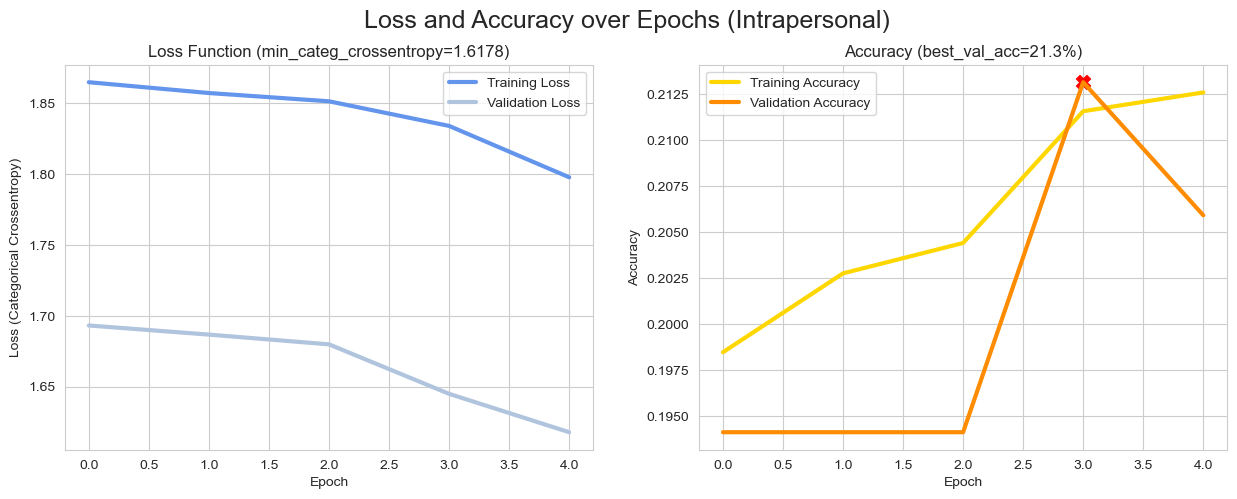

794/794 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step
Some y Predicted	 [1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2]
Some y Label		 [3 2 1 2 3 3 4 4 5 3 5 3 2 1 1 1 4 3 1 6 3 2 4 2 5 0 4 1 2 0]
precision: [0.    0.198 0.285 0.    0.    0.    0.   ]
recall: [0.    0.743 0.399 0.    0.    0.    0.   ]
fscore: [0.    0.312 0.333 0.    0.    0.    0.   ]
fscore_micro: 0.218


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


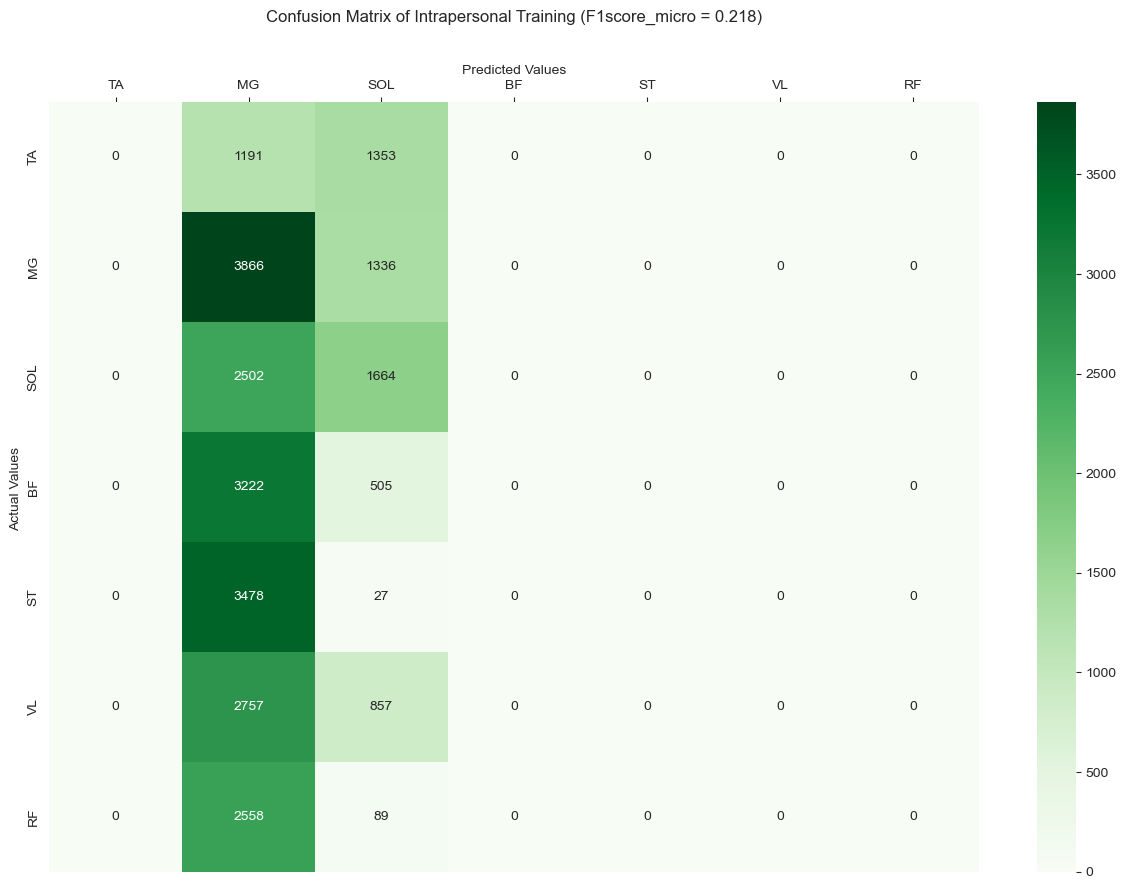

199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Some y Predicted	 [1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1]
Some y Label		 [2 4 4 2 4 3 6 4 4 6 5 4 4 4 1 4 0 3 3 2 2 1 5 2 1 1 3 3 4 2]
precision: [0.    0.187 0.301 0.    0.    0.    0.   ]
recall: [0.    0.737 0.407 0.    0.    0.    0.   ]
fscore: [0.    0.298 0.346 0.    0.    0.    0.   ]
fscore_micro: 0.213


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


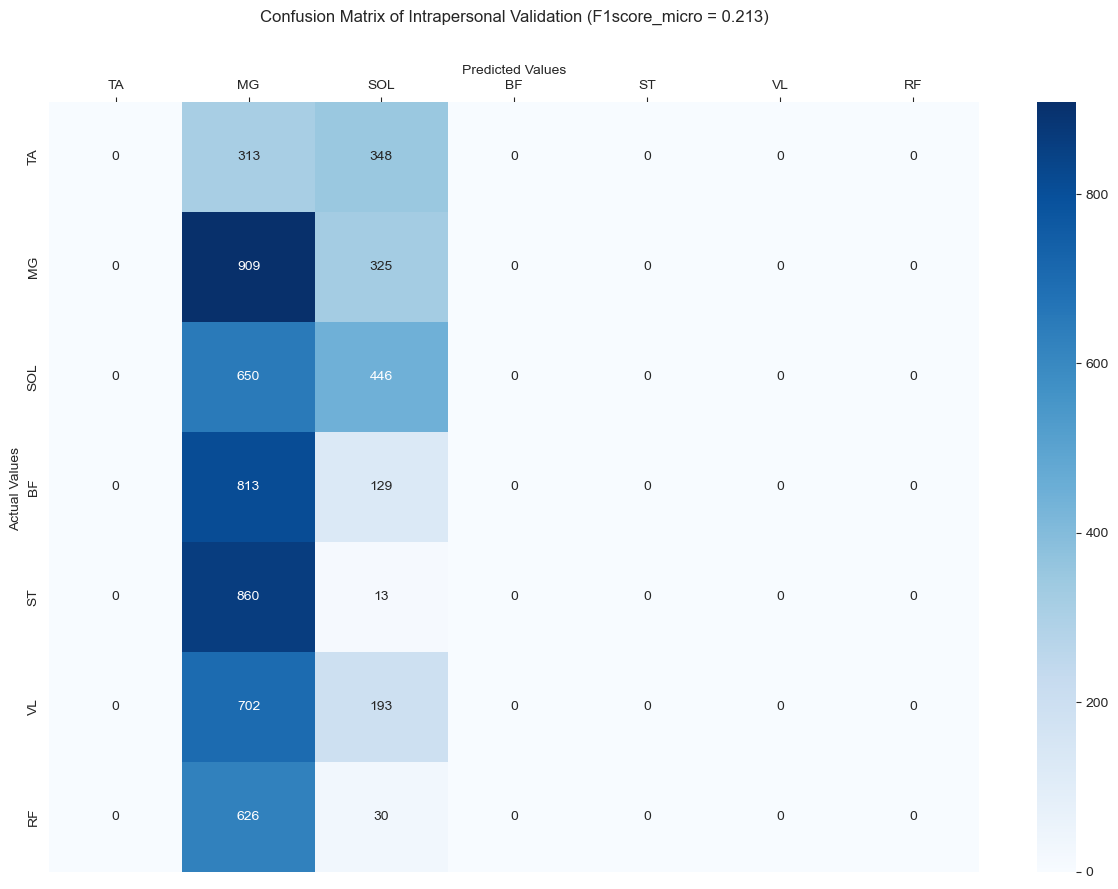

In [27]:
## Plotting Loss and Accuracy Metrics over Epochs
plotting_loss_and_accuracy_over_epochs(history_name, f"Loss and Accuracy over Epochs (Intrapersonal)", True)

## Serializing Datasets (train and val)
x_train, y_train, x_val, y_val = serializing_datasets(train_dataset, valid_dataset)

## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
# Confusion Matrix in Training
plot_confusion_matrix(x_train, y_train, "Greens", f"Confusion Matrix of Intrapersonal Training ", True)
# Confusion Matrix in Testing
intrapersonal_precision, intrapersonal_recall, intrapersonal_f1, intrapersonal_f1_micro  =\
	plot_confusion_matrix(x_val, y_val, "Blues", f"Confusion Matrix of Intrapersonal Validation ", True)

In [28]:
# Log the best validation accuracy and loss
# wandb.log({"intrapersonal_best_accuracy":  best_val_accuracy,
#            "intrapersonal_min_val_loss": min_val_categ_crossentropy,
#            "intrapersonal_precision": intrapersonal_precision,
#            "intrapersonal_recall": intrapersonal_recall,
#            "intrapersonal_f1": intrapersonal_f1,
           # "intrapersonal_f1_micro": intrapersonal_f1_micro})
# wandb.finish()

### Interpersonal Training with Leave-One-Subject-Out Cross-Validation (LOSOCV)

In [29]:
num_subjects = len(all_subjects_loo_data)
best_loo_validation_per_subject = [];  min_loo_val_loss_per_subject = []
all_interpersonal_precision = []; all_interpersonal_recall = []
all_interpersonal_f1 = []; all_interpersonal_f1_micro = []
all_percentages=[]; histories_list=[]

In [30]:
# LOSOCV Training Loop
for loo_subject in range(num_subjects):  # Change range to start from 0 to num_subjects-1
	print(f"Training with subject_{subjects[loo_subject]} as a validation set")

	# Deleting the old directories of the previously trained models
	clear_and_create_directory("model1")
	clear_and_create_directory("histories")

	# Initialising Wandb logging
	# wandb.init(project='Thesis', entity='firass-koli', config=config, name=f"loo_test_subject_{subjects[loo_subject]}",
	#            group=note)
	# optimizer = Adam(learning_rate=wandb.config.learning_rate)

	# Creating a new model
	model1 = model_creation()

	# Compiling the model
	model1.compile(loss=categorical_crossentropy, 
	               # optimizer=optimizer, 
	               metrics=['accuracy'])

	# Defining checkpoint path correctly with adjusted loo_subject index
	cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras', save_best_only=True,
	                     monitor='val_accuracy', mode='max')

	# Prepare training and validation datasets
	loo_valid_dataset = all_subjects_loo_data[loo_subject]
	loo_train_datasets = [d for i, d in enumerate(all_subjects_loo_data) if i != loo_subject]
	train_dataset = reduce(lambda x, y: x.concatenate(y), loo_train_datasets).shuffle(buffer_size=34000)  # Shuffle here
	# train_dataset = reduce(lambda x, y: x.concatenate(y), loo_train_datasets)  # Correct concatenation using lambda

	# Train the model with the correct validation dataset
	# with tf.device("/gpu:0"):
	history = model1.fit(train_dataset, validation_data=valid_dataset, epochs= epochs,
	                      callbacks=[cp, scheduler ]) #, WandbMetricsLogger(log_freq=5)])

	histories_list.append(history)
	# Log the best validation accuracy and loss for each subject
	best_val_accuracy = round(max(history.history['val_accuracy']), 3) * 100
	min_val_loss = round(min(history.history['val_loss']), 3)

	print(f"Best Validation Accuracy for using Subject_{subjects[loo_subject]} as loo: {best_val_accuracy}%")
	print(f"Minimum Validation Loss for using Subject_{subjects[loo_subject]} as loo: {min_val_loss}")

	best_loo_validation_per_subject.append(best_val_accuracy)
	min_loo_val_loss_per_subject.append(min_val_loss)

	# Saving history
	history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_loss})_loo_subject_{subjects[loo_subject]}'
	np.save(history_name + '.npy', history.history)

	## Plotting Loss and Accuracy Metrics over Epochs
	plotting_loss_and_accuracy_over_epochs(history_name,
	                                       f'Subject_{subjects[loo_subject]} Loss and Accuracy over Epochs (Interpersonal with Subject_{subjects[loo_subject]} as loo) ')

	## Metric Functions: Confusion Matrix, Precision, Recall and F-1Scores
	# Serializing Datasets (train and val)
	x_train, y_train, x_val, y_val = serializing_datasets(train_dataset, loo_valid_dataset)
	# Confusion Matrix in Training
	plot_confusion_matrix(x_train, y_train, 'Greens',
	                      f'Subject_{subjects[loo_subject]} Confusion Matrix of Interpersonal LOO Training WITHOUT Subject_{subjects[loo_subject]} ')
	# Confusion Matrix in Testing
	interpersonal_precision, interpersonal_recall, interpersonal_f1, interpersonal_f1_micro = \
		plot_confusion_matrix(x_val, y_val, 'Blues',
		                      f'Subject_{subjects[loo_subject]} Confusion Matrix of Interpersonal LOO_Validation Subject_{subjects[loo_subject]} ')
	# Classification Samples
	display_classification_samples(model1, x_val, y_val,
	                               f'Subject_{subjects[loo_subject]} Classification Samples of Interpersonal LOO_Validation ')
	# Wrong Classification %
	percentages = plot_wrong_classification_percentages(model1, x_val, y_val,
	                                    f'Subject_{subjects[loo_subject]} Percentages of Wrongly Classified Muscles in Interpersonal LOO_Validation ')

	# Log the best validation accuracy and loss
	# wandb.log({"interpersonal_best_val_accuracy": best_val_accuracy,
	#            "interpersonal_min_val_loss": min_val_loss,
	           # "interpersonal_precision": interpersonal_precision,
	           # "interpersonal_recall": interpersonal_recall,
	           # "interpersonal_f1": interpersonal_f1,
	           # "interpersonal_f1_micro": interpersonal_f1_micro
	           # })
	# wandb.finish()

	all_interpersonal_precision.append(interpersonal_precision)
	all_interpersonal_recall.append(interpersonal_recall)
	all_interpersonal_f1.append(interpersonal_f1)
	all_interpersonal_f1_micro.append(interpersonal_f1_micro)
	all_percentages.append(percentages)


Training with subject_156 as a validation set
Old "model1" directory of the previous model deleted!
Old "histories" directory of the previous model deleted!
A Fresh New Model Created!
Epoch 1/5
     33/Unknown 39s 1s/step - accuracy: 0.1584 - loss: 1.9448

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1591 - loss: 1.9431 - val_accuracy: 0.1941 - val_loss: 1.6955 - learning_rate: 0.0010
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1852 - loss: 1.9331 - val_accuracy: 0.1941 - val_loss: 1.6865 - learning_rate: 0.0010
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1773 - loss: 1.9280 - val_accuracy: 0.1941 - val_loss: 1.6803 - learning_rate: 0.0010
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.1929 - loss: 1.9216 - val_accuracy: 0.1941 - val_loss: 1.6825 - learning_rate: 0.0010
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1982 - loss: 1.9198 - val_accuracy: 0.1941 - val_loss: 1.6844 - learning_rate: 0.0010
Best Validation Accuracy for using Subject_156 as loo: 19.400000000000002%
Minimum Validation Loss for using Subject_156 as loo: 1.68
912/912 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step
Some y Predicted	 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Some y L

C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Some y Predicted	 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Some y Label		 [1 1 1 1 0 3 1 1 2 6 1 1 5 3 3 6 3 2 0 0 5 2 1 2 0 3 1 6 3 3]
precision: [0.    0.277 0.    0.    0.    0.    0.   ]
recall: [0. 1. 0. 0. 0. 0. 0.]
fscore: [0.    0.434 0.    0.    0.    0.    0.   ]
fscore_micro: 0.277


C:\Users\firas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Training with subject_185 as a validation set
Old "model1" directory of the previous model deleted!
Old "histories" directory of the previous model deleted!
A Fresh New Model Created!
Epoch 1/5
     31/Unknown 34s 1s/step - accuracy: 0.1809 - loss: 1.9437

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1817 - loss: 1.9417 - val_accuracy: 0.1941 - val_loss: 1.6948 - learning_rate: 0.0010
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2145 - loss: 1.9261 - val_accuracy: 0.1941 - val_loss: 1.6912 - learning_rate: 0.0010
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2098 - loss: 1.9235 - val_accuracy: 0.1941 - val_loss: 1.6871 - learning_rate: 0.0010
Epoch 4/5
10/31 ━━━━━━━━━━━━━━━━━━━━ 18s 883ms/step - accuracy: 0.2027 - loss: 1.9232


KeyboardInterrupt



Error in callback <function flush_figures at 0x00000192CAF05080> (for post_execute):



KeyboardInterrupt



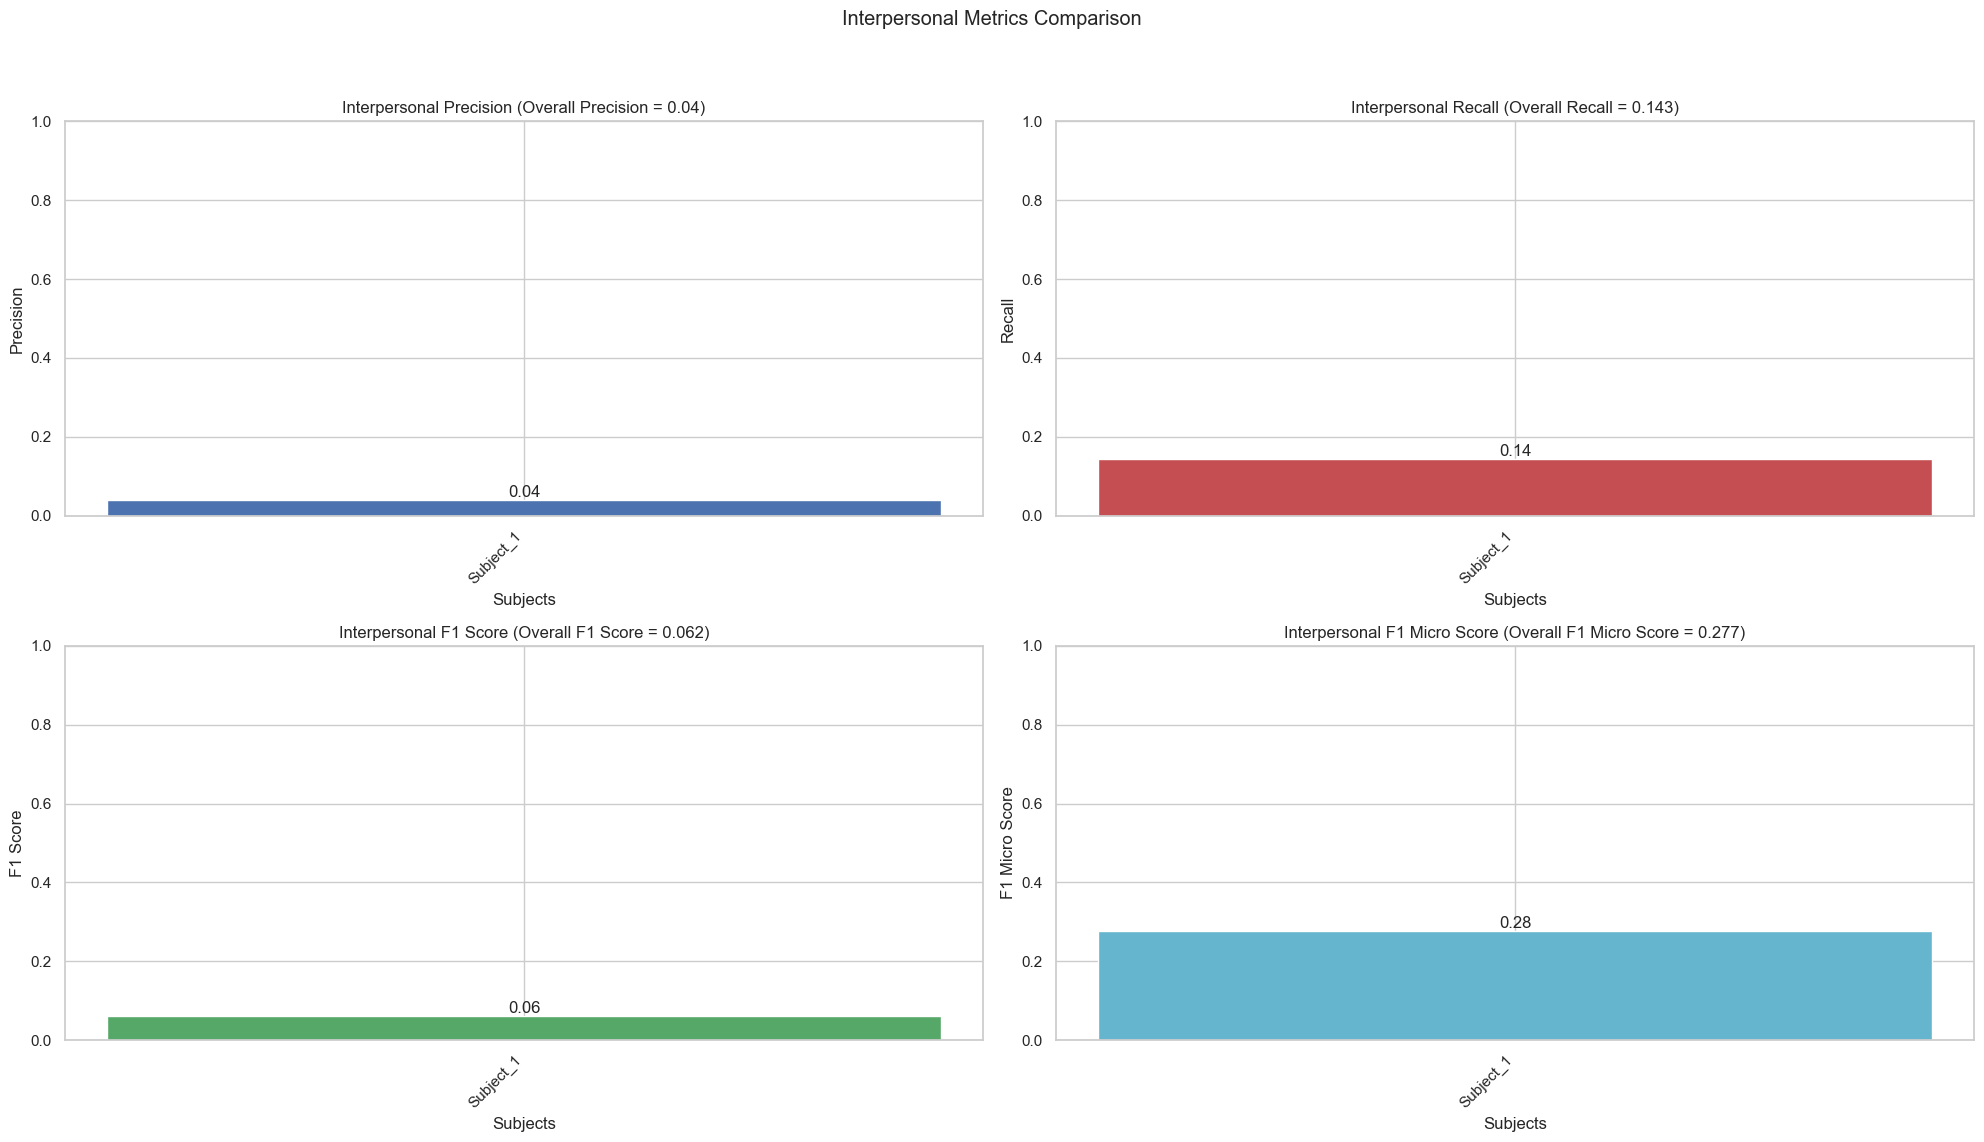

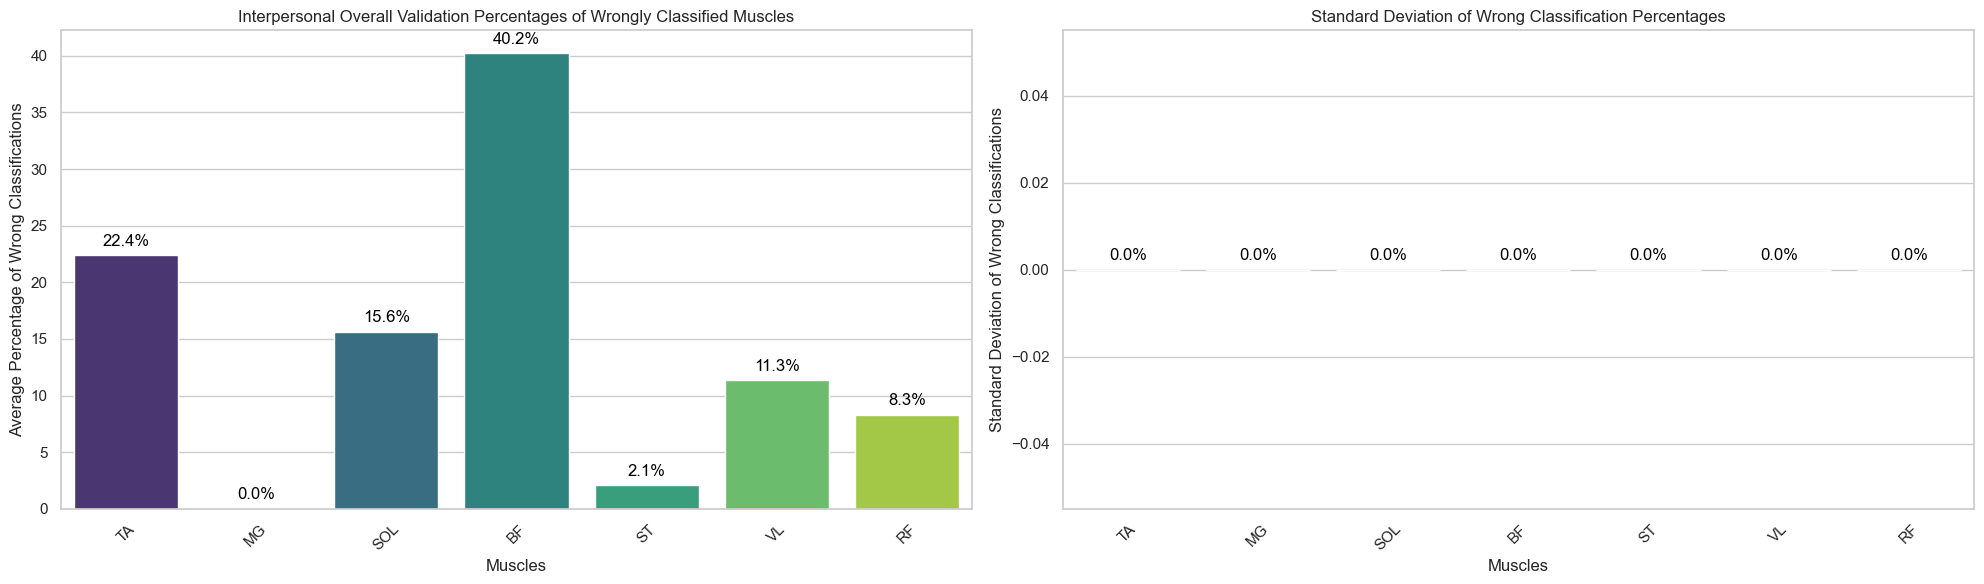

In [31]:
# Plotting 
plot_interpersonal_metrics_bar(all_interpersonal_precision, all_interpersonal_recall, all_interpersonal_f1, all_interpersonal_f1_micro)
plot_average_wrong_classification_percentages(all_percentages)

In [32]:
avg_loss = []
avg_val_loss = []
avg_accuracy = []
avg_val_accuracy = []

# Calculate the length of training (assuming all subjects have the same number of epochs)
num_epochs = len(histories_list[0]['loss'])

# Summing up all metrics by epoch
for i in range(num_epochs):
    epoch_loss = np.mean([h['loss'][i] for h in histories_list])
    epoch_val_loss = np.mean([h['val_loss'][i] for h in histories_list])
    epoch_accuracy = np.mean([h['accuracy'][i] for h in histories_list])
    epoch_val_accuracy = np.mean([h['val_accuracy'][i] for h in histories_list])
    
    avg_loss.append(epoch_loss)
    avg_val_loss.append(epoch_val_loss)
    avg_accuracy.append(epoch_accuracy)
    avg_val_accuracy.append(epoch_val_accuracy)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss Plot
ax1.plot(avg_loss, label='Average Training Loss', color='blue')
ax1.plot(avg_val_loss, label='Average Validation Loss', color='red')
ax1.set_title('Average Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy Plot
ax2.plot(avg_accuracy, label='Average Training Accuracy', color='blue')
ax2.plot(avg_val_accuracy, label='Average Validation Accuracy', color='red')
ax2.set_title('Average Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

TypeError: 'History' object is not subscriptable